In [36]:
#LIBRARIES

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import IPython.display as ipd

from glob import glob #list all the files of a director

import pandas as pd
import numpy as np

#extras
import os
from sklearn.model_selection import train_test_split

import skimage.io

import resampy 

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, recall_score

#HYPERPARAMETERS 
from sklearn.model_selection import GridSearchCV

#BALANCING DATA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


In [39]:
# nice colours for plots
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## METADATA

In [40]:
import glob
import pandas as pd

audio_dataset_path = 'C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data'

file_paths = glob.glob('C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data/*/*')
data = {'file_name': [os.path.basename(file_path) for file_path in file_paths],
        'label': [os.path.basename(os.path.dirname(file_path)) for file_path in file_paths]}
audio_metadata = pd.DataFrame(data)
audio_metadata

,file_name,label
0,549a46d8-9c84-430e-ade8-97eae2bef787-143013077...,belly_pain
1,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013849...,belly_pain
2,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013850...,belly_pain
3,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013851...,belly_pain
4,643D64AD-B711-469A-AF69-55C0D5D3E30F-143013852...,belly_pain
...,...,...
452,d5abedab-9ed5-48d0-a83b-fc00c33d6d6b-143007919...,tired
453,d6cda191-4962-4308-9a36-46d5648a95ed-143158788...,tired
454,d6cda191-4962-4308-9a36-46d5648a95ed-143158789...,tired
455,d6cda191-4962-4308-9a36-46d5648a95ed-143161658...,tired


In [41]:
# check for imbalanced dataset:

audio_metadata.label.value_counts()

hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: label, dtype: int64

<AxesSubplot: >

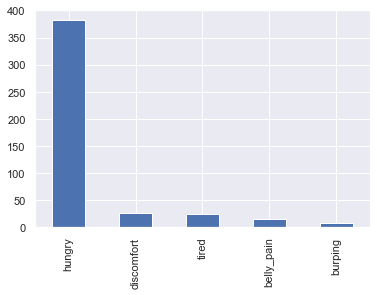

In [42]:
sns.set()
audio_metadata["label"].value_counts().plot(kind="bar")

## Extract features

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [43]:
n_mfcc = 20

# mfccs = librosa.feature.mfcc(y=amplitudes, sr=sr, n_mfcc=n_mfcc)
# print(mfccs.shape)

In [44]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [45]:
import numpy as np
from tqdm import tqdm #to see the progress of the interation

audio_dataset_path = 'C:/Users/migue/Documents/IRONHACK/FINAL PROJECT/audio_data/'

### Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
extracted_features=[]

for index_num,row in tqdm(audio_metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["label"])+'/',str(row["file_name"]))
    final_class_labels = row["label"]
    data = features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

457it [00:17, 25.67it/s]


In [46]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','label'])
extracted_features_df.head()

,feature,label
0,"[-499.4247, 112.08116, -49.807816, -18.21421, ...",belly_pain
1,"[-503.241, 155.62462, -53.089634, -9.338754, 1...",belly_pain
2,"[-426.70706, 157.33188, -52.70597, -14.5242, 1...",belly_pain
3,"[-389.0387, 168.44524, -67.22318, -17.126297, ...",belly_pain
4,"[-317.4329, 176.0357, -62.427364, -4.4671364, ...",belly_pain


In [47]:
# defining a function to extract columns from the 'feature' column:

audio_features = extracted_features_df.join(extracted_features_df['feature'].apply(lambda x: pd.Series(x)))
audio_features.drop('feature', axis=1, inplace=True)
audio_features.head()

,label,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,4.624222,-5.119436,-7.728714,-3.538106,-7.979645,-2.615498,7.271394,7.611597,7.803081,5.120747
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,-1.737597,-19.827585,-6.832434,-5.233813,-18.699984,-4.740155,-1.861880,-12.453473,1.433591,8.583754
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-3.337778,-20.508154,-7.740295,-2.097857,-13.885005,-4.229779,-2.091619,-11.650046,-2.397524,0.084169
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,1.840204,-22.669641,-11.450462,-3.493709,-13.468182,-0.194263,3.394778,-6.323487,1.412753,-1.218252
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,-0.988255,-22.390026,-5.400581,-2.447238,-16.219675,-0.631569,0.520929,-10.393013,0.306009,-3.319665


### Removing hungry label

In [48]:
audio_features[audio_features["label"]== "hungry"]

audio_features = audio_features.drop(index = audio_features[audio_features["label"]== "hungry"].index)

In [49]:
# Replace the label column with the new labels

audio_features["label"].value_counts()

discomfort    27
tired         24
belly_pain    16
burping        8
Name: label, dtype: int64

In [50]:
audio_features_label = audio_features.copy()

audio_features_label

,label,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,belly_pain,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,4.624222,-5.119436,-7.728714,-3.538106,-7.979645,-2.615498,7.271394,7.611597,7.803081,5.120747
1,belly_pain,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,-1.737597,-19.827585,-6.832434,-5.233813,-18.699984,-4.740155,-1.861880,-12.453473,1.433591,8.583754
2,belly_pain,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-3.337778,-20.508154,-7.740295,-2.097857,-13.885005,-4.229779,-2.091619,-11.650046,-2.397524,0.084169
3,belly_pain,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,1.840204,-22.669641,-11.450462,-3.493709,-13.468182,-0.194263,3.394778,-6.323487,1.412753,-1.218252
4,belly_pain,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,-0.988255,-22.390026,-5.400581,-2.447238,-16.219675,-0.631569,0.520929,-10.393013,0.306009,-3.319665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,tired,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,...,3.683591,-11.450652,-7.048715,4.499153,-5.402944,-6.877699,-0.258983,-4.307193,-3.198995,-0.406327
453,tired,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,...,2.422461,-9.671777,-4.804976,2.316418,-2.162425,3.896538,6.718845,-2.593693,-3.064267,-0.761209
454,tired,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,...,5.701275,-17.436428,0.273278,3.064165,-13.133533,0.258504,5.245041,-2.875592,6.929228,6.768970
455,tired,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,...,12.159773,-12.433870,-2.912987,-0.598551,-13.805822,3.189518,4.267688,-7.096861,7.629454,8.684285


## Split x_train, y_train

In [51]:
### Split the dataset into independent and dependent dataset
x = audio_features_label.drop('label', axis=1)
y = audio_features_label['label']

In [52]:
x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,-9.128422,4.624222,-5.119436,-7.728714,-3.538106,-7.979645,-2.615498,7.271394,7.611597,7.803081,5.120747
1,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,-7.877410,-1.737597,-19.827585,-6.832434,-5.233813,-18.699984,-4.740155,-1.861880,-12.453473,1.433591,8.583754
2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,-10.134473,-3.337778,-20.508154,-7.740295,-2.097857,-13.885005,-4.229779,-2.091619,-11.650046,-2.397524,0.084169
3,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,-8.384931,1.840204,-22.669641,-11.450462,-3.493709,-13.468182,-0.194263,3.394778,-6.323487,1.412753,-1.218252
4,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,-8.081997,-0.988255,-22.390026,-5.400581,-2.447238,-16.219675,-0.631569,0.520929,-10.393013,0.306009,-3.319665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,-5.701318,3.683591,-11.450652,-7.048715,4.499153,-5.402944,-6.877699,-0.258983,-4.307193,-3.198995,-0.406327
453,-382.692291,63.694927,-67.268288,-28.363958,4.281721,-21.530396,-2.429851,15.150540,-4.196824,-2.480641,2.422461,-9.671777,-4.804976,2.316418,-2.162425,3.896538,6.718845,-2.593693,-3.064267,-0.761209
454,-330.265472,100.000862,-100.228058,-40.944801,6.029012,-24.748707,1.218462,7.054237,-14.843027,7.616994,5.701275,-17.436428,0.273278,3.064165,-13.133533,0.258504,5.245041,-2.875592,6.929228,6.768970
455,-335.744446,148.460281,-110.957558,-9.835780,20.750916,-59.526371,-2.249499,26.060947,-29.037586,-8.832440,12.159773,-12.433870,-2.912987,-0.598551,-13.805822,3.189518,4.267688,-7.096861,7.629454,8.684285


In [53]:
y.shape
x.shape

(75, 20)

In [54]:
### Train Test Split
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [55]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(60, 20)
(60,)
(15, 20)
(15,)


## Balancing data

In [56]:
train = pd.concat([x_train, y_train], axis=1)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
452,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,-5.701318,...,-11.450652,-7.048715,4.499153,-5.402944,-6.877699,-0.258983,-4.307193,-3.198995,-0.406327,tired
27,-397.120605,151.246979,-65.386208,-1.931688,21.394295,-41.003788,-8.806436,9.512874,-22.120047,-5.855665,...,-20.062885,-3.301815,-0.947833,-16.609972,-2.800039,2.008044,-7.274409,0.432884,-1.618947,discomfort
49,-265.649139,134.414963,-96.223511,-19.944441,13.617352,-42.273296,4.097267,17.961351,-28.440102,-2.451402,...,-24.127048,-6.762351,9.201861,-11.651779,-2.235002,10.979747,0.525974,2.657277,2.324663,discomfort
442,-342.027771,141.739761,-60.807823,-2.419143,18.199274,-38.537094,-9.946051,-0.310781,-29.078543,-4.608864,...,-21.600599,-2.323322,2.554183,-12.584600,2.529248,5.687406,-6.534361,2.809739,2.441992,tired
438,-419.991882,105.610344,-10.740171,-10.283562,1.592099,-14.710582,-3.541446,3.408146,-10.692015,-10.810895,...,-16.878305,-11.448807,-8.655626,-12.627223,-7.423747,-3.978273,-6.756103,-4.856238,-4.264986,tired


In [57]:
train["label"].value_counts()

discomfort    20
tired         18
belly_pain    15
burping        7
Name: label, dtype: int64

#### OVERSAMPLING

In [246]:
# old sample sizes:

train_hungry = train[train["category"] == "hungry"]
train_nothungry = train[train["category"] == "not_hungry"]


print(train_hungry.shape)
print(train_nothungry.shape)

(303, 41)
(62, 41)


In [247]:
train_nothungry_over = resample(train_nothungry, # <--- undersample from here
                                   replace = True, # <--- we need replacement since we don't have enough datapoints
                                   n_samples=len(train_hungry))# <--- make both sets the same size

In [248]:
train_over = pd.concat([train_hungry, train_nothungry_over])
print(train_over.shape)
train_over.head()

(606, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,hungry
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,hungry
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,hungry
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,hungry
295,-323.106140,107.602089,-38.831306,-25.561359,-5.242953,-33.480370,-14.614306,9.044759,-6.424458,-4.776411,...,4.065837,5.763697,2.614671,0.447468,-0.253474,-2.133288,-4.075959,-2.455865,-0.160012,hungry


In [249]:
#seperating features from label again 

x_train_over = train_over.drop("category", axis=1)
y_train_over = train_over["category"]

#### UNDERSAMPLING

In [250]:
train_hungry_under = resample(train_hungry, # <--- undersample from here
                                   replace = False, # <--- we don't need replacement since we have enough datapoints
                                   n_samples=len(train_nothungry))# <--- make both sets the same size

In [251]:
train_under = pd.concat([train_hungry_under, train_nothungry])
print(train_under.shape)
train_under.head()

(124, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
258,-411.477844,123.028496,-50.756210,-28.341145,-3.121509,-29.391165,-7.402414,3.949917,-11.994132,0.683491,...,-9.724190,-10.778250,1.346529,5.885926,2.670073,5.704072,9.270051,5.075645,-2.872779,hungry
235,-388.781128,90.958847,-41.586193,-18.860346,8.338795,-15.875065,-9.522689,-3.843307,-16.876623,-5.576123,...,0.224467,-1.700199,-3.086384,-3.278862,-1.588094,0.535838,1.126580,1.681125,2.181479,hungry
243,-295.672058,128.503845,-120.284996,-1.889562,36.217979,-54.595657,-12.197618,15.029808,-26.757444,-1.106009,...,-3.032155,-3.184210,2.162886,-1.027239,-2.145279,1.211732,-2.599186,-3.431699,1.855150,hungry
58,-364.895844,80.195671,-35.093002,-14.971576,6.184248,-16.126644,-4.589623,6.591949,-9.353189,-8.968859,...,-0.939787,-2.245137,-0.347123,0.734760,1.156361,1.497194,1.526564,2.461107,1.221293,hungry
137,-465.006927,164.687714,-63.512939,2.243343,28.426105,-42.354465,-7.649408,20.379528,-22.216249,-16.028538,...,-3.331861,-4.646342,-0.526432,-1.268573,-1.741729,1.366283,-1.454283,-3.012194,0.313241,hungry


In [252]:
#seperating features from label again 

x_train_under = train_under.drop("category", axis=1)
y_train_under = train_under["category"]

#### SMOTE

In [253]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE function:
#sm = SMOTE(sampling_strategy={'belly_pain': len("hungry")}) #sampling_strategy == ratio = 1
smote = SMOTE()


# using SMOTE model to give us a balanced x_train and y_train:
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

#for the minority class, SMOTE will create new datapoints based on kkn models 
# so that the x_train and y_train end up with the same lenght

## MACHINE LEARNING

## * KNN Classifier

#### Raw Data

In [58]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train, y_train)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train, y_train))

#CLASSIFICATION REPORT

pred = knn.predict(x_test)
print(classification_report(y_test, pred))

0.26666666666666666
0.6333333333333333
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.75      0.43      0.55         7
       tired       0.50      0.17      0.25         6

    accuracy                           0.27        15
   macro avg       0.31      0.15      0.20        15
weighted avg       0.55      0.27      0.35        15



In [59]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train, y_train)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 8}

In [60]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=8)

#training the model
knn_grid.fit(x_train, y_train)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train, y_train))

#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.26666666666666666
0.5
              precision    recall  f1-score   support

  belly_pain       0.11      1.00      0.20         1
     burping       0.00      0.00      0.00         1
  discomfort       0.50      0.29      0.36         7
       tired       1.00      0.17      0.29         6

    accuracy                           0.27        15
   macro avg       0.40      0.36      0.21        15
weighted avg       0.64      0.27      0.30        15



#### Oversampling Data

In [257]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_over, y_train_over)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_over, y_train_over))

#some overfitting

0.7065217391304348
0.9207920792079208


In [258]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_over, y_train_over)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 1}

In [259]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=1)

#training the model
knn_grid.fit(x_train_over, y_train_over)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_over, y_train_over))


#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.75
1.0
              precision    recall  f1-score   support

      hungry       0.86      0.85      0.85        79
  not_hungry       0.14      0.15      0.15        13

    accuracy                           0.75        92
   macro avg       0.50      0.50      0.50        92
weighted avg       0.76      0.75      0.75        92



#### Undersampling Data

In [260]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_under, y_train_under)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_under, y_train_under))

#some overfitting

0.6413043478260869
0.8709677419354839


In [261]:
#create a grid

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_under, y_train_under)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 3}

In [262]:

knn_grid = KNeighborsClassifier(n_neighbors=1)

#training the model
knn_grid.fit(x_train_under, y_train_under)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_under, y_train_under))

#CLASSIFICATION REPORT

pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.5978260869565217
1.0
              precision    recall  f1-score   support

      hungry       0.89      0.61      0.72        79
  not_hungry       0.18      0.54      0.27        13

    accuracy                           0.60        92
   macro avg       0.54      0.57      0.50        92
weighted avg       0.79      0.60      0.66        92



#### SMOTE Data

In [263]:
from sklearn.neighbors import KNeighborsClassifier

#create model:
knn = KNeighborsClassifier(n_neighbors = 3)

#training the model:
knn.fit(x_train_SMOTE, y_train_SMOTE)

#score without tunning 
print(knn.score(x_test,y_test))
print(knn.score(x_train_SMOTE, y_train_SMOTE))

#some overfitting

0.6739130434782609
0.8910891089108911


In [264]:
###HYPER TUNNING
#create a grid
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(x_train_SMOTE, y_train_SMOTE)

#best params
best_params=grid_search.best_params_
best_params

{'n_neighbors': 2}

In [265]:
###HYPER TUNNED MODEL

knn_grid = KNeighborsClassifier(n_neighbors=2)

#training the model
knn_grid.fit(x_train_SMOTE, y_train_SMOTE)

#score with tunning 
print(knn_grid.score(x_test,y_test))
print(knn_grid.score(x_train_SMOTE, y_train_SMOTE))


#CLASSIFICATION REPORT
pred = knn_grid.predict(x_test)
print(classification_report(y_test, pred))

0.75
0.995049504950495
              precision    recall  f1-score   support

      hungry       0.88      0.82      0.85        79
  not_hungry       0.22      0.31      0.26        13

    accuracy                           0.75        92
   macro avg       0.55      0.57      0.55        92
weighted avg       0.79      0.75      0.77        92



## * Decision Tree Classifier

<function matplotlib.pyplot.show(close=None, block=None)>

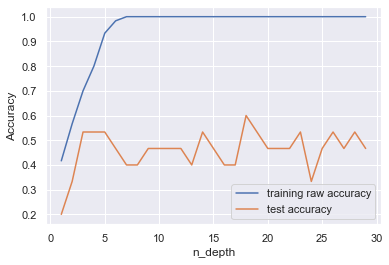

In [61]:
#hyperparameter tunning (one parameter only):

max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(x_train, y_train)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train, y_train))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training raw accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

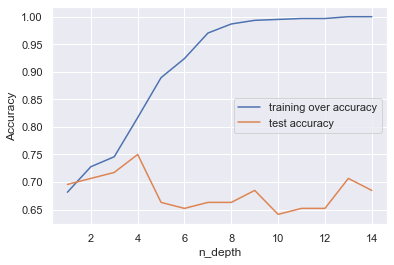

In [267]:
##### OVERSAMPLED
max_depth = range(1,15)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(x_train_over, y_train_over)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_over, y_train_over))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training over accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

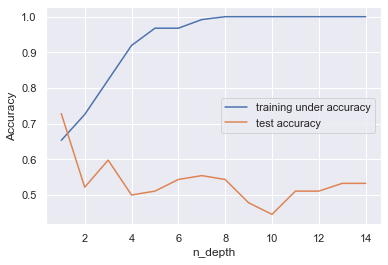

In [268]:
##### UNDERSAMPLED
max_depth = range(1,15)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth= depth)
    model.fit(x_train_under, y_train_under)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_under, y_train_under))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training under accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

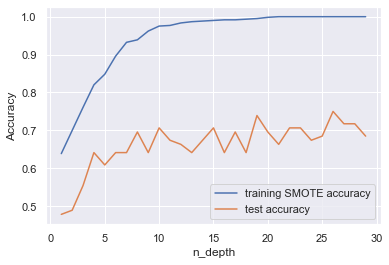

In [269]:
##### SMOTE
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth= depth)
    model.fit(x_train_SMOTE, y_train_SMOTE)
    test.append(model.score(x_test,y_test))
    train.append(model.score(x_train_SMOTE, y_train_SMOTE))
    
# we quickly see overfitting properties
plt.plot(max_depth, train, label="training SMOTE accuracy")
plt.plot(max_depth, test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show

In [64]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(x_train, y_train)

print("Test data accuracy is",tree.score(x_test,y_test))
print("Train data accuracy is",tree.score(x_train, y_train))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.5333333333333333
Train data accuracy is 0.7
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.71      0.71      0.71         7
       tired       0.60      0.50      0.55         6

    accuracy                           0.53        15
   macro avg       0.33      0.30      0.31        15
weighted avg       0.57      0.53      0.55        15



In [271]:
##OVERSAMPLED DATA

tree = DecisionTreeClassifier(max_depth=2)

#train our model:
tree.fit(x_train_over,y_train_over)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train oversampled data accuracy is", tree.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.7065217391304348
Train oversampled data accuracy is 0.7277227722772277
              precision    recall  f1-score   support

      hungry       0.86      0.78      0.82        79
  not_hungry       0.15      0.23      0.18        13

    accuracy                           0.71        92
   macro avg       0.51      0.51      0.50        92
weighted avg       0.76      0.71      0.73        92



In [272]:
##UNDERSAMPLED DATA

tree = DecisionTreeClassifier(max_depth=1)

#train our model:
tree.fit(x_train_under,y_train_under)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train undersampled data accuracy is", tree.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.7282608695652174
Train undersampled data accuracy is 0.6532258064516129
              precision    recall  f1-score   support

      hungry       0.86      0.81      0.84        79
  not_hungry       0.17      0.23      0.19        13

    accuracy                           0.73        92
   macro avg       0.52      0.52      0.52        92
weighted avg       0.77      0.73      0.75        92



In [273]:
##SMOTE DATA

#train our model:
tree.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test data accuracy is",tree.score(x_test,y_test))
print("Train smote data accuracy is", tree.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = tree.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.4782608695652174
Train smote data accuracy is 0.6386138613861386
              precision    recall  f1-score   support

      hungry       0.90      0.44      0.59        79
  not_hungry       0.17      0.69      0.27        13

    accuracy                           0.48        92
   macro avg       0.53      0.57      0.43        92
weighted avg       0.79      0.48      0.55        92



## * Random Forests

In [65]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators= 100,max_depth= 5)

forest.fit(x_train, y_train)

#overfitting

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train raw data accuracy is", forest.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.26666666666666666
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.50      0.43      0.46         7
       tired       0.25      0.17      0.20         6

    accuracy                           0.27        15
   macro avg       0.19      0.15      0.17        15
weighted avg       0.33      0.27      0.30        15



In [275]:
##OVERSAMPLED DATA

#train our model:
forest.fit(x_train_over,y_train_over)

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train oversampled data accuracy is", forest.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.7934782608695652
Train oversampled data accuracy is 0.971947194719472
              precision    recall  f1-score   support

      hungry       0.88      0.87      0.88        79
  not_hungry       0.29      0.31      0.30        13

    accuracy                           0.79        92
   macro avg       0.59      0.59      0.59        92
weighted avg       0.80      0.79      0.80        92



In [276]:
##UNDERSAMPLED DATA

#train our model:
forest.fit(x_train_under,y_train_under)

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train undersampled data accuracy is", forest.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.5760869565217391
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

      hungry       0.90      0.57      0.70        79
  not_hungry       0.19      0.62      0.29        13

    accuracy                           0.58        92
   macro avg       0.55      0.59      0.49        92
weighted avg       0.80      0.58      0.64        92



In [277]:
##SMOTE DATA

#train our model:
forest.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test data accuracy is", forest.score(x_test, y_test))
print("Train smote data accuracy is", forest.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test data accuracy is 0.6847826086956522
Train smote data accuracy is 0.9471947194719472
              precision    recall  f1-score   support

      hungry       0.90      0.71      0.79        79
  not_hungry       0.23      0.54      0.33        13

    accuracy                           0.68        92
   macro avg       0.57      0.62      0.56        92
weighted avg       0.81      0.68      0.73        92



In [66]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 100)]
#max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid={"n_estimators":n_estimators,
            #"max_features":max_features,
            "max_depth":max_depth}
            #"min_samples_split":min_samples_split,
            #"min_samples_leaf":min_samples_leaf,
            #"bootstrap":bootstrap}

In [67]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=forest,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train, y_train)

random_search.best_params_

{'n_estimators': 816, 'max_depth': 87}

In [69]:
forest=RandomForestClassifier(n_estimators = 816 ,max_depth= 87)

forest.fit(x_train, y_train)

#overfitting

#score:
print("Test raw data accuracy is", forest.score(x_test, y_test))
print("Train raw data accuracy is", forest.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.3333333333333333
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.60      0.43      0.50         7
       tired       0.40      0.33      0.36         6

    accuracy                           0.33        15
   macro avg       0.25      0.19      0.22        15
weighted avg       0.44      0.33      0.38        15



## SVM

In [70]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=1000000)
svm.fit(x_train,y_train)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train raw data accuracy is", svm.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.4
Train raw data accuracy is 0.7
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.60      0.43      0.50         7
       tired       0.40      0.33      0.36         6

    accuracy                           0.33        15
   macro avg       0.25      0.19      0.22        15
weighted avg       0.44      0.33      0.38        15



In [283]:
##OVERSAMPLED DATA

#train our model:
svm.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train oversampled data accuracy is", svm.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.7717391304347826
Train oversampled data accuracy is 0.7194719471947195
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



In [284]:
##UNDERSAMPLED DATA

#train our model:
svm.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train undersampled data accuracy is", svm.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6304347826086957
Train undersampled data accuracy is 0.7580645161290323
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



In [285]:
##SMOTE DATA

#train our model:
svm.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", svm.score(x_test, y_test))
print("Train smote data accuracy is", svm.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6847826086956522
Train smote data accuracy is 0.6963696369636964
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



## Logistic Regression

In [71]:
##RAW DATA

from sklearn.linear_model import LogisticRegression

#initialize model:

log_model = LogisticRegression(max_iter=10000) #max_iter=10000

#train our model:
log_model.fit(x_train,y_train)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train raw data accuracy is", log_model.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.4666666666666667
Train raw data accuracy is 0.75
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         1
     burping       0.00      0.00      0.00         1
  discomfort       0.60      0.43      0.50         7
       tired       0.40      0.33      0.36         6

    accuracy                           0.33        15
   macro avg       0.25      0.19      0.22        15
weighted avg       0.44      0.33      0.38        15



In [287]:
##OVERSAMPLED DATA

#train our model:
log_model.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train oversampled data accuracy is", log_model.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6630434782608695
Train oversampled data accuracy is 0.7194719471947195
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



In [288]:
##UNDERSAMPLED DATA

#train our model:
log_model.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train undersampled data accuracy is", log_model.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6521739130434783
Train undersampled data accuracy is 0.7338709677419355
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



In [289]:
##SMOTE DATA

#train our model:
log_model.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", log_model.score(x_test, y_test))
print("Train smote data accuracy is", log_model.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = forest.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.6739130434782609
Train smote data accuracy is 0.7046204620462047
              precision    recall  f1-score   support

      hungry       0.86      1.00      0.92        79
  not_hungry       0.00      0.00      0.00        13

    accuracy                           0.86        92
   macro avg       0.43      0.50      0.46        92
weighted avg       0.74      0.86      0.79        92



## BOOSTING

### ADA Boosting

In [73]:
from sklearn.ensemble import AdaBoostClassifier
ada_class = AdaBoostClassifier(tree,n_estimators=100)

ada_class.fit(x_train,y_train)


#score:
print("Test  data accuracy is", ada_class.score(x_test, y_test))
print("Train raw data accuracy is", ada_class.score(x_train,y_train))

# ##OVERSAMPLED DATA

# #train our model:
# ada_class.fit(x_train_over,y_train_over)

# #score:
# print("Train oversampled data accuracy is", ada_class.score(x_train_over,y_train_over))


# ##UNDERSAMPLED DATA

# #train our model:
# ada_class.fit(x_train_under,y_train_under)

# #score:
# print("Train undersampled data accuracy is", ada_class.score(x_train_under,y_train_under))

# ##SMOTE DATA

# #train our model:
# ada_class.fit(x_train_SMOTE,y_train_SMOTE)

# #score:
# print("Train smote data accuracy is", ada_class.score(x_train_SMOTE,y_train_SMOTE))

Test  data accuracy is 0.4
Train raw data accuracy is 1.0


### Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
gb_class = GradientBoostingClassifier(max_depth=5, n_estimators=100)

gb_class.fit(x_train, y_train)


#score:
print("Test raw data accuracy is", gb_class.score(x_test, y_test))
print("Train raw data accuracy is", gb_class.score(x_train,y_train))

# ##OVERSAMPLED DATA

# #train our model:
# gb_class.fit(x_train_over,y_train_over)

# #score:
# print("Train oversampled data accuracy is", gb_class.score(x_train_over,y_train_over))


# ##UNDERSAMPLED DATA

# #train our model:
# gb_class.fit(x_train_under,y_train_under)

# #score:
# print("Train undersampled data accuracy is", gb_class.score(x_train_under,y_train_under))

# ##SMOTE DATA

# #train our model:
# gb_class.fit(x_train_SMOTE,y_train_SMOTE)

# #score:
# print("Train smote data accuracy is", gb_class.score(x_train_SMOTE,y_train_SMOTE))

Test raw data accuracy is 0.3333333333333333
Train raw data accuracy is 1.0


### Extreme Gradient Boosting

In [81]:
audio_features_label["label"].value_counts()

discomfort    27
tired         24
belly_pain    16
burping        8
Name: label, dtype: int64

In [83]:
# Converting hungry in 1 and not hungry in 0:
audio_features_0 = audio_features_label.copy()

#define the replacement values as a dictionary

replace_map = {'discomfort': 0, 'tired': 1, 'belly_pain': 2, 'burping': 3}

# replace the values in the 'color' column
audio_features_0['label'] = audio_features_0['label'].replace(replace_map)

#audio_features_nothungry[audio_features_nothungry["category"] == 1]

audio_features_0.head()

,label,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,2,-499.424713,112.081161,-49.807816,-18.214211,13.028866,-26.151291,-14.420481,7.603708,-11.387850,...,4.624222,-5.119436,-7.728714,-3.538106,-7.979645,-2.615498,7.271394,7.611597,7.803081,5.120747
1,2,-503.240997,155.624619,-53.089634,-9.338754,18.954021,-30.361124,-10.490327,-0.191979,-25.778471,...,-1.737597,-19.827585,-6.832434,-5.233813,-18.699984,-4.740155,-1.861880,-12.453473,1.433591,8.583754
2,2,-426.707062,157.331879,-52.705971,-14.524200,11.352674,-37.552837,-15.138313,0.320166,-24.708115,...,-3.337778,-20.508154,-7.740295,-2.097857,-13.885005,-4.229779,-2.091619,-11.650046,-2.397524,0.084169
3,2,-389.038696,168.445236,-67.223183,-17.126297,13.631199,-41.452286,-14.523580,-1.005277,-31.239029,...,1.840204,-22.669641,-11.450462,-3.493709,-13.468182,-0.194263,3.394778,-6.323487,1.412753,-1.218252
4,2,-317.432892,176.035706,-62.427364,-4.467136,17.833765,-48.702011,-19.136120,-3.011306,-32.136478,...,-0.988255,-22.390026,-5.400581,-2.447238,-16.219675,-0.631569,0.520929,-10.393013,0.306009,-3.319665


In [84]:
### Split the dataset into independent and dependent dataset
x = audio_features_0.drop('label', axis=1)
y = audio_features_0['label']

In [85]:
### Train Test Split
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [86]:
train = pd.concat([x_train, y_train], axis=1)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
452,-549.808960,87.620987,-52.848518,-4.859076,28.336473,-17.738258,-12.495114,6.238529,-11.197370,-5.701318,...,-11.450652,-7.048715,4.499153,-5.402944,-6.877699,-0.258983,-4.307193,-3.198995,-0.406327,1
27,-397.120605,151.246979,-65.386208,-1.931688,21.394295,-41.003788,-8.806436,9.512874,-22.120047,-5.855665,...,-20.062885,-3.301815,-0.947833,-16.609972,-2.800039,2.008044,-7.274409,0.432884,-1.618947,0
49,-265.649139,134.414963,-96.223511,-19.944441,13.617352,-42.273296,4.097267,17.961351,-28.440102,-2.451402,...,-24.127048,-6.762351,9.201861,-11.651779,-2.235002,10.979747,0.525974,2.657277,2.324663,0
442,-342.027771,141.739761,-60.807823,-2.419143,18.199274,-38.537094,-9.946051,-0.310781,-29.078543,-4.608864,...,-21.600599,-2.323322,2.554183,-12.584600,2.529248,5.687406,-6.534361,2.809739,2.441992,1
438,-419.991882,105.610344,-10.740171,-10.283562,1.592099,-14.710582,-3.541446,3.408146,-10.692015,-10.810895,...,-16.878305,-11.448807,-8.655626,-12.627223,-7.423747,-3.978273,-6.756103,-4.856238,-4.264986,1


In [303]:
train.shape

(365, 41)

##### OVERSAMPLING

In [306]:
# old sample sizes:

train_hungry = train[train["category"] == 1]
train_nothungry = train[train["category"] == 0]


print(train_hungry.shape)
print(train_nothungry.shape)

(303, 41)
(62, 41)


In [307]:
train_nothungry_over = resample(train_nothungry, # <--- undersample from here
                                   replace = True, # <--- we need replacement since we don't have enough datapoints
                                   n_samples=len(train_hungry))# <--- make both sets the same size

In [308]:
train_over = pd.concat([train_hungry, train_nothungry_over])
print(train_over.shape)
train_over.head()

(606, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
141,-258.423950,239.174896,-3.597260,8.841642,31.073893,-16.249443,0.903809,11.036634,-18.024740,-4.845502,...,-2.531755,-5.525385,-3.534909,-4.060783,-5.719588,-2.922280,-2.325560,-3.443725,-2.434219,1
293,-355.442352,124.710594,-52.769253,-34.160305,4.574441,-22.938278,-17.212320,-1.698827,-9.802575,-0.844767,...,3.440170,2.412681,1.027842,1.208941,-0.125557,-1.442946,-2.517964,-2.875237,-1.660491,1
52,-523.431824,137.423218,-18.293631,0.016314,18.337383,-21.331781,-9.218897,9.865731,-9.552913,-7.619267,...,-3.237782,-4.885705,-3.987910,-2.569896,-3.619754,-2.978716,-2.323520,-3.452256,-2.452348,1
74,-255.786163,167.835861,-100.291290,3.766301,24.010281,-60.293919,-2.762302,17.007700,-27.183031,2.805851,...,-1.883172,0.049351,4.547917,-0.952618,0.363429,3.148814,-1.890258,-0.916096,1.869166,1
295,-323.106140,107.602089,-38.831306,-25.561359,-5.242953,-33.480370,-14.614306,9.044759,-6.424458,-4.776411,...,4.065837,5.763697,2.614671,0.447468,-0.253474,-2.133288,-4.075959,-2.455865,-0.160012,1


In [309]:
#seperating features from label again 

x_train_over = train_over.drop("category", axis=1)
y_train_over = train_over["category"]

#### UNDERSAMPLING

In [310]:
train_hungry_under = resample(train_hungry, # <--- undersample from here
                                   replace = False, # <--- we don't need replacement since we have enough datapoints
                                   n_samples=len(train_nothungry))# <--- make both sets the same size

In [311]:
train_under = pd.concat([train_hungry_under, train_nothungry])
print(train_under.shape)
train_under.head()

(124, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,category
167,-373.562683,160.018433,-104.632637,-17.670549,35.562679,-33.337891,-9.195043,9.233662,-21.140984,0.085760,...,3.455433,1.797713,3.072806,0.553751,1.169925,2.947687,-0.647308,1.609954,4.768319,1
414,-378.577942,106.972755,-25.109734,-20.241934,-1.800706,-23.187515,-8.757077,9.632323,-7.430875,-13.644821,...,0.045528,-1.201289,-0.875340,0.729938,1.223474,0.138993,-1.378384,-0.430679,0.443666,1
199,-330.937469,130.015167,-42.046539,-10.371113,13.665381,-36.992401,-31.697224,-12.826623,-21.979488,-6.679254,...,2.358515,3.633297,6.761785,6.236598,2.827866,2.783920,0.820684,-2.834546,-1.866090,1
424,-363.999298,105.855629,-50.544193,-47.947884,-14.607754,-22.090534,-6.385252,7.059819,-5.950194,-7.670593,...,-1.139017,-4.936616,-1.367352,0.274812,-1.631515,-0.626226,-1.363694,-4.689954,-3.226901,1
257,-503.445740,89.169464,-42.785255,-25.322504,3.281674,-21.066267,-16.182665,2.392004,0.132859,2.220946,...,0.193990,0.975505,2.023956,0.651748,-1.365228,0.151134,-0.267838,-2.684144,-1.489353,1


In [312]:
#seperating features from label again 

x_train_under = train_under.drop("category", axis=1)
y_train_under = train_under["category"]

#### SMOTE

In [77]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE function:
#sm = SMOTE(sampling_strategy={'belly_pain': len("hungry")}) #sampling_strategy == ratio = 1
smote = SMOTE()


# using SMOTE model to give us a balanced x_train and y_train:
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

#for the minority class, SMOTE will create new datapoints based on kkn models 
# so that the x_train and y_train end up with the same lenght

#### ** MODEL

In [87]:
import xgboost

xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

xgb_class.fit(x_train,y_train)
xgb_class.score(x_test,y_test)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train raw data accuracy is", xgb_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.3333333333333333
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.50      0.33      0.40         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1

    accuracy                           0.33        15
   macro avg       0.28      0.19      0.23        15
weighted avg       0.48      0.33      0.39        15



In [ ]:
## random grid

In [88]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000)]
max_depth = [int(x) for x in np.linspace(1, 100)]

random_grid={"n_estimators":n_estimators,"max_depth":max_depth}


In [89]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train, y_train)

random_search.best_params_

{'n_estimators': 102, 'max_depth': 83}

In [90]:

xgb_class=xgboost.XGBClassifier(n_estimators=102,max_depth=83)

xgb_class.fit(x_train,y_train)
xgb_class.score(x_test,y_test)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train raw data accuracy is", xgb_class.score(x_train,y_train))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5333333333333333
Train raw data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       1.00      0.50      0.67         6
           2       0.25      1.00      0.40         1
           3       0.00      0.00      0.00         1

    accuracy                           0.53        15
   macro avg       0.51      0.52      0.43        15
weighted avg       0.79      0.53      0.60        15



In [320]:
##OVERSAMPLED DATA

#train our model:
xgb_class.fit(x_train_over,y_train_over)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train oversampled data accuracy is", xgb_class.score(x_train_over,y_train_over))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.8043478260869565
Train oversampled data accuracy is 0.9933993399339934
              precision    recall  f1-score   support

           0       0.33      0.38      0.36        13
           1       0.90      0.87      0.88        79

    accuracy                           0.80        92
   macro avg       0.61      0.63      0.62        92
weighted avg       0.82      0.80      0.81        92



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train, y_train)

random_search.best_params_

In [331]:
##UNDERSAMPLED DATA
xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

#train our model:
xgb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", xgb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5760869565217391
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.19      0.62      0.29        13
           1       0.90      0.57      0.70        79

    accuracy                           0.58        92
   macro avg       0.55      0.59      0.49        92
weighted avg       0.80      0.58      0.64        92



In [332]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_under, y_train_under)

random_search.best_params_

{'n_estimators': 388, 'max_depth': 21}

In [334]:
##UNDERSAMPLED DATA
xgb_class=xgboost.XGBClassifier(n_estimators=388,max_depth=21)

#train our model:
xgb_class.fit(x_train_under,y_train_under)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train undersampled data accuracy is", xgb_class.score(x_train_under,y_train_under))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.5543478260869565
Train undersampled data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.18      0.62      0.28        13
           1       0.90      0.54      0.68        79

    accuracy                           0.55        92
   macro avg       0.54      0.58      0.48        92
weighted avg       0.79      0.55      0.62        92



In [322]:
##SMOTE DATA
xgb_class=xgboost.XGBClassifier(n_estimators=10,max_depth=5)

#train our model:
xgb_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train smote data accuracy is", xgb_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.717391304347826
Train smote data accuracy is 0.9900990099009901
              precision    recall  f1-score   support

           0       0.22      0.38      0.28        13
           1       0.88      0.77      0.82        79

    accuracy                           0.72        92
   macro avg       0.55      0.58      0.55        92
weighted avg       0.79      0.72      0.75        92



In [333]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=xgb_class,param_distributions=random_grid,cv=5,n_iter=10)

random_search.fit(x_train_SMOTE, y_train_SMOTE)

random_search.best_params_

{'n_estimators': 102, 'max_depth': 63}

In [335]:
##SMOTE DATA
xgb_class=xgboost.XGBClassifier(n_estimators=102,max_depth=63)

#train our model:
xgb_class.fit(x_train_SMOTE,y_train_SMOTE)

#score:
print("Test raw data accuracy is", xgb_class.score(x_test, y_test))
print("Train smote data accuracy is", xgb_class.score(x_train_SMOTE,y_train_SMOTE))

#CLASSIFICATION REPORT
pred = xgb_class.predict(x_test)
print(classification_report(y_test, pred))

Test raw data accuracy is 0.782608695652174
Train smote data accuracy is 1.0
              precision    recall  f1-score   support

           0       0.32      0.46      0.37        13
           1       0.90      0.84      0.87        79

    accuracy                           0.78        92
   macro avg       0.61      0.65      0.62        92
weighted avg       0.82      0.78      0.80        92

